# Final Code: Machine Learning for Corporate Training Effectiveness

In [ ]:
import pandas as pd

# Load datasets
employee_df = pd.read_csv('employee_data.csv')
training_df = pd.read_csv('training_and_development_data.csv')
engagement_df = pd.read_csv('employee_engagement_survey_data.csv')
recruitment_df = pd.read_csv('recruitment_data.csv')

# Merge datasets
df = pd.merge(training_df, employee_df, left_on='Employee ID', right_on='EmpID', how='left')
df = pd.merge(df, engagement_df, on='Employee ID', how='left')

print("Final merged dataset shape:", df.shape)
df.head()

Final merged dataset shape: (3000, 39)


,Employee ID,Training Date,Training Program Name,Training Type,Training Outcome,Location,Trainer,Training Duration(Days),Training Cost,EmpID,...,GenderCode,LocationCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,Survey Date,Engagement Score,Satisfaction Score,Work-Life Balance Score
0,1001,21-Sep-22,Customer Service,Internal,Failed,Port Greg,Amanda Daniels,4,510.83,1001,...,Female,1749,Black,Married,Fully Meets,3,10-10-2022,2,5,5
1,1002,19-Jul-23,Leadership Development,Internal,Failed,Brandonview,Brittany Chambers,2,582.37,1002,...,Female,2135,Asian,Widowed,Fully Meets,3,03-08-2023,4,5,3
2,1003,24-Feb-23,Technical Skills,Internal,Incomplete,Port Briannahaven,Mark Roberson,4,777.06,1003,...,Female,2176,White,Married,Fully Meets,3,03-01-2023,2,5,2
3,1004,12-Jan-23,Customer Service,Internal,Completed,Knightborough,Richard Fisher,2,824.30,1004,...,Male,2140,Black,Single,Fully Meets,3,30-07-2023,3,5,3
4,1005,12-May-23,Communication Skills,External,Passed,Bruceshire,Heather Shaffer,4,145.99,1005,...,Male,1844,Black,Divorced,Fully Meets,3,19-06-2023,2,4,5


<ipython-input-2-e185bb511703>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Training Date'] = pd.to_datetime(df['Training Date'], errors='coerce', dayfirst=True)


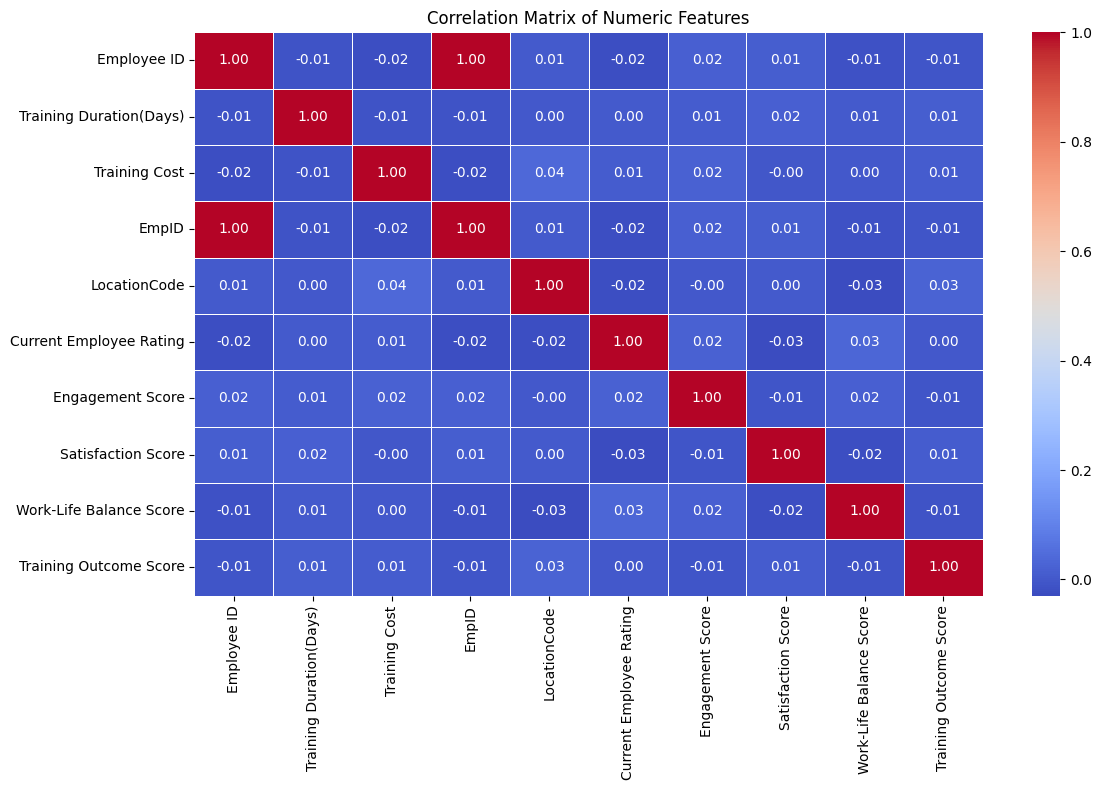

In [ ]:
# Preprocessing and feature engineering
import matplotlib.pyplot as plt
import seaborn as sns

df['Training Date'] = pd.to_datetime(df['Training Date'], errors='coerce', dayfirst=True)
df['Survey Date'] = pd.to_datetime(df['Survey Date'], errors='coerce', dayfirst=True)

outcome_map = {'Failed': 0, 'Incomplete': 1, 'Completed': 2, 'Passed': 3}
df['Training Outcome Score'] = df['Training Outcome'].map(outcome_map)

for col in ['Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score']:
    df[col] = df[col].fillna(df[col].median())

numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [ ]:
# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df[df['Training Outcome Score'].notnull()]
y = df['Training Outcome Score'].apply(lambda x: 1 if x >= 2 else 0)

X = df[[
    'Training Duration(Days)', 'Training Cost',
    'Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score',
    'Current Employee Rating'
]].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

def evaluate_model(name, y_test, y_pred):
    return {
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'Precision': round(precision_score(y_test, y_pred), 3),
        'Recall': round(recall_score(y_test, y_pred), 3),
        'F1 Score': round(f1_score(y_test, y_pred), 3)
    }

results = [
    evaluate_model("Logistic Regression", y_test, lr.predict(X_test)),
    evaluate_model("Random Forest", y_test, rf.predict(X_test)),
    evaluate_model("XGBoost", y_test, xgb.predict(X_test))
]

pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:07:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.483,0.498,0.502,0.500
1,Random Forest,0.495,0.510,0.489,0.499
2,XGBoost,0.497,0.511,0.518,0.514


<Figure size 640x480 with 0 Axes>

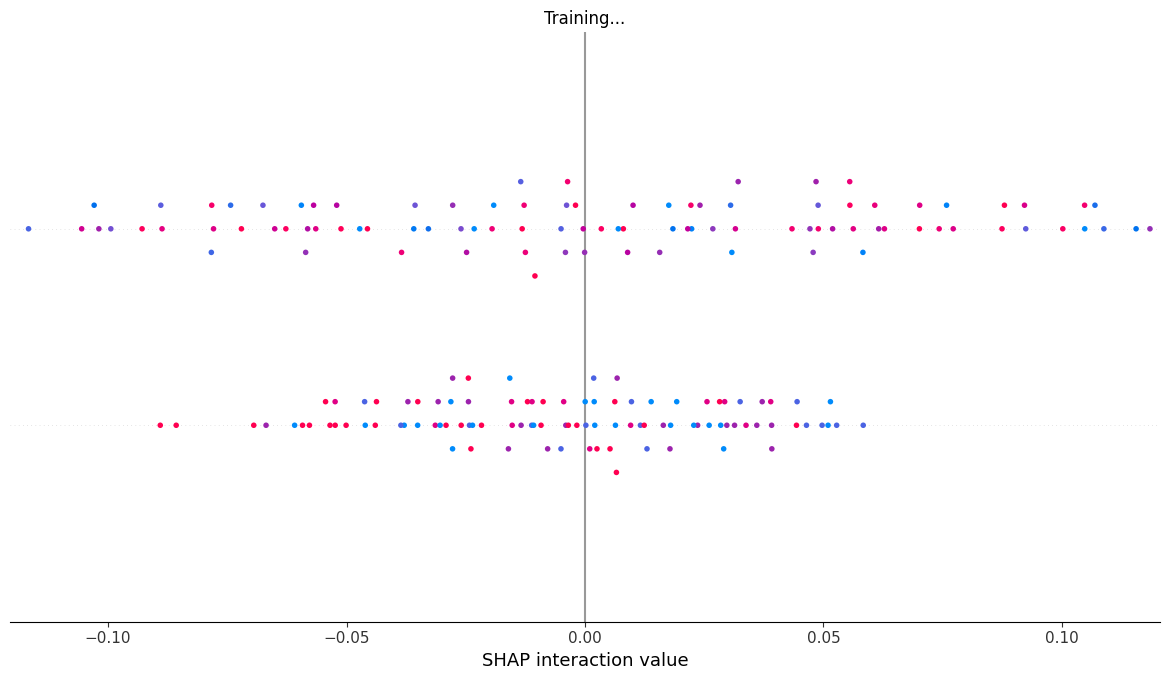

In [ ]:
# SHAP analysis for interpretability
import shap
import numpy as np

explainer = shap.TreeExplainer(rf)
X_sample = X_test.sample(n=100, random_state=1)
shap_vals = explainer.shap_values(X_sample)

shap.summary_plot(shap_vals, X_sample, plot_type="bar")

X_sample.columns length: 6
shap_mean length: 6


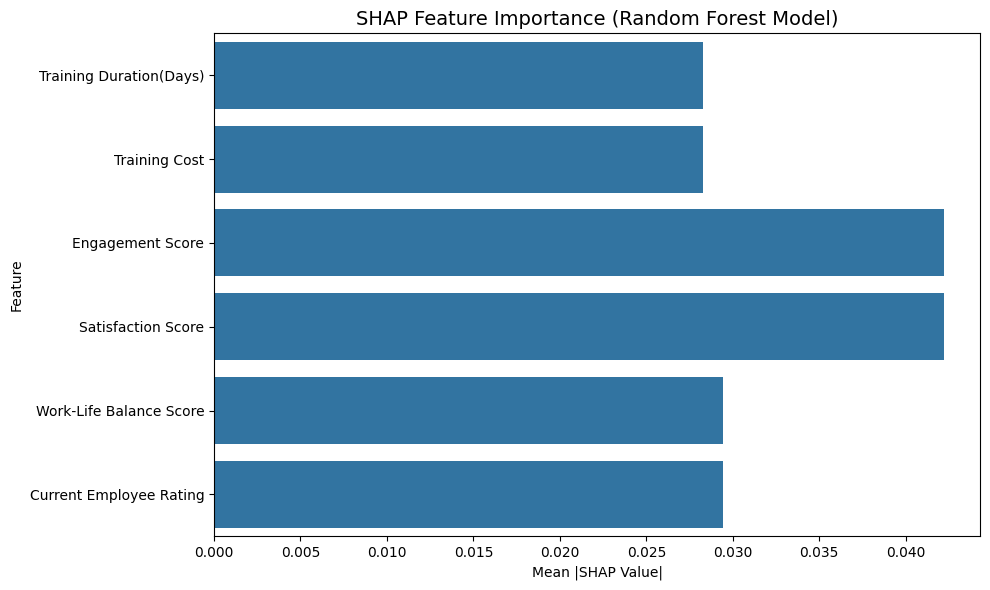

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (100 samples, 6 features)
X_sample = X_test.sample(100, random_state=42)

# Explain model predictions using SHAP
explainer = shap.TreeExplainer(rf)  # assuming you're using Random Forest
shap_values = explainer.shap_values(X_sample)

# If it's a binary classifier, shap_values is a list: [class_0_values, class_1_values]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_class_1 = shap_values[1]  # Focus on "completed/passed"
else:
    shap_vals_class_1 = shap_values  # e.g. XGBoost returns directly

# Now compute mean absolute SHAP values per feature
shap_mean = np.abs(shap_vals_class_1).mean(axis=0)

# Sanity check
print("X_sample.columns length:", len(X_sample.columns))
print("shap_mean length:", len(shap_mean))

# Ensure both are 1D arrays/lists
features = X_sample.columns.tolist()
shap_mean_flat = shap_mean.ravel().tolist()

# Build DataFrame correctly using zip
shap_df = pd.DataFrame(list(zip(features, shap_mean_flat)), columns=['Feature', 'Mean |SHAP Value|'])



# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_df, x='Mean |SHAP Value|', y='Feature')
plt.title("SHAP Feature Importance (Random Forest Model)", fontsize=14)
plt.tight_layout()
plt.show()